miniGAP (in repository)  
currently compartmentalizing this into multiple notebooks

In [442]:
# Import everything immediately
# This looks messy right now. I can sort it by type of packages later
import sys
sys.path.append('../code')
from Molecular_Dynamics import generate_md_traj
from Generate_Descriptors import get_dscribe_descriptors

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tfp.math.psd_kernels
from itertools import islice
from  tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
from ase.io import read

In [2]:
if False:
    from miniGAP_functions import LearnEnergyFromSoap, LearnFromSoap

    import matplotlib
    import numpy.random as rand
    import time
    from ase import Atoms
    from ase.calculators.emt import EMT
    from ase.calculators.lj import LennardJones
    from ase.calculators.morse import MorsePotential
    #from xtb.ase.calculator import XTB
    from ase.optimize import BFGS
    from ase.optimize import MDMin
    from ase.io import read
    from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
    from ase.md.verlet import VelocityVerlet
    from ase.md.nvtberendsen import NVTBerendsen
    from ase import units
    from dscribe.descriptors import SOAP
    from numpy import polyfit
    from numpy import poly1d
    import os
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
    import tensorflow as tf
    import tensorflow_probability as tfp
    from  tensorflow_probability import distributions as tfd
    import gpflow.optimizers as gpopts
    import numpy.random as rand
    from sklearn.gaussian_process.kernels import RBF
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.metrics.pairwise import rbf_kernel
    tfk = tfp.math.psd_kernels
    from sklearn.metrics import mean_squared_error
    from matplotlib import animation
    from IPython.display import HTML
    from matplotlib.colors import LogNorm
    from matplotlib.ticker import LogFormatterMathtext
    from mpl_toolkits import mplot3d
    from matplotlib import cm
    from os.path import join

In [202]:
# some basic helper functions

def PrintNoScientificNotation(*x, digits=5):
    np.set_printoptions(suppress=True) # Do not print in scientific notation
    print(*x)
    np.set_printoptions(suppress=False)
       
def TickTock(func, *args, **kwargs):
    tick = time.time()
    func_output = func(*args, **kwargs)
    tock = time.time()
    return func_output, tock - tick

def Distance(x1, x2):
    x1 = np.array(x1); x2 = np.array(x2)
    return np.sqrt(((x1 - x2) ** 2).sum())

In [482]:
SMALL_SIZE = 11
MEDIUM_SIZE = 13
BIG_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)     # fontsize of the figure title

Fiddling with the code from https://github.com/SINGROUP/dscribe/issues/63 to explore the new 'attach' flag

In [255]:
import numpy as np
from ase import Atoms
from ase.vibrations import Vibrations
from dscribe.descriptors import SOAP

atoms = Atoms(symbols='HF', positions=[[0, 0, 0], [0, 0, .9382]], pbc=False)
soap = SOAP(rcut = 6.0, nmax = 1, lmax = 1, species = atoms.get_chemical_symbols(), dtype="float64" )

print('\nSOAP.create:')
soaps = soap.create(atoms)  # 6 features in total

for i in range(len(soaps)):
    print("[ ", end="")
    for j in range(len(soaps[i])):
        print(" {:6.2f} ".format(soaps[i,j]), end="")
    print(" ]")

# DSCRIBE derivatives
atom_coordinates = [[0,0,0], [0,0,.9382]]# + np.ones(atoms.positions.shape)*1e-6#atoms.positions + np.ones(atoms.positions.shape)*1e-8
dscribe_derivs = soap.derivatives(atoms, method='numerical', return_descriptor=False, attach=True, positions=atom_coordinates)
nonzero_min =np.min(np.abs(np.ma.masked_equal(dscribe_derivs, 0, copy=True)))
print('\nSOAP.derivatives:')
print(nonzero_min)
#PrintNoScientificNotation(dscribe_derivs)
n_centers, n_atoms, _, n_features = dscribe_derivs.shape
dscribe_derivs = np.moveaxis(dscribe_derivs, 0, 2).reshape(( 3 * n_atoms, n_atoms * n_features)).T

#PrintNoScientificNotation(dscribe_derivs)
for i in range(len(dscribe_derivs)):
    print("[ ", end="")
    for j in range(len(dscribe_derivs[i])):
        print(" {:6.2f} ".format(dscribe_derivs[i,j]), end="")
    print(" ]")


# Numerical derivatives using finite displacements
eps = 1e-5  # finite difference
vib = Vibrations(atoms, delta=eps, nfree=2)
atoms_displacements = list(vib.iterimages())  # create finite displacements

s = soap.create(atoms_displacements)
s -= s[0]  # subtract soap for unperturbed structure
s = s[1:]  # pop unperturbed structure
numerical_derivs = 0.5 * (s[1::2] - s[::2]) / eps  # centered finite difference scheme
numerical_derivs = numerical_derivs.reshape((3 * len(atoms), len(s[0].ravel()))).T
print('\nDerivatives by finite displacements:')
#print(numerical_derivs)
for i in range(len(numerical_derivs)):
    print("[ ", end="")
    for j in range(len(numerical_derivs[i])):
        print(" {:6.2f} ".format(numerical_derivs[i,j]), end="")
    print(" ]")


SOAP.create:
[    6.25    0.00    4.15    0.00    2.75    0.18  ]
[    2.75    0.18    4.15    0.00    6.25    0.00  ]

SOAP.derivatives:
0.06721823726990594
[    0.00    0.00    0.00    0.00    0.00    0.00  ]
[    0.00    0.00    0.00    0.00    0.00    0.00  ]
[    0.00    0.00    0.00    0.00    0.00   -3.63  ]
[    0.00    0.00    0.28    0.00    0.00    0.00  ]
[    0.00    0.00    0.00    0.00    0.00   -4.81  ]
[    0.00    0.00    0.00    0.00    0.00    0.07  ]
[    0.00    0.00    4.81    0.00    0.00    0.00  ]
[    0.00    0.00   -0.07    0.00    0.00    0.00  ]
[    0.00    0.00    3.63    0.00    0.00    0.00  ]
[    0.00    0.00    0.00    0.00    0.00   -0.28  ]
[    0.00    0.00    0.00    0.00    0.00    0.00  ]
[    0.00    0.00    0.00    0.00    0.00    0.00  ]

Derivatives by finite displacements:
[    0.00    0.00    0.00    0.00    0.00    0.00  ]
[    0.00    0.00    0.00    0.00    0.00    0.00  ]
[    0.00    0.00    3.63    0.00    0.00   -3.63  ]
[    0.0

In [ ]:
atoms = Atoms(symbols='HF', positions=[[7.5, 7.5, 7.5], [7.5, 7.5, 8.4382]], pbc=False)
soap = SOAP(rcut = 6.0, nmax = 1, lmax = 0, species = atoms.get_chemical_symbols())

print('\nSOAP.create:')
print(soap.create(atoms))  # 6 features in total


# DSCRIBE derivatives
dscribe_derivs = soap.derivatives(atoms, method='auto', return_descriptor=False)
n_centers, n_atoms, _, n_features = dscribe_derivs.shape
dscribe_derivs = np.moveaxis(dscribe_derivs, 0, 2).reshape(( 3 * n_atoms, n_atoms * n_features)).T
print('\nSOAP.derivatives:')
print(dscribe_derivs)

In [232]:
positions=[[7.5, 7.5, 7.5], [7.5, 7.5, 8.4382]]
atoms = Atoms(symbols='HF', positions=positions, pbc=False)
soap = SOAP(rcut = 6.0, nmax = 1, lmax = 1, species = atoms.get_chemical_symbols(), dtype="float64")

print('\nSOAP.create:')
print(soap.create(atoms))  # 6 features in total

# DSCRIBE derivatives
dscribe_derivs = soap.derivatives(atoms, method='auto', return_descriptor=False)
n_centers, n_atoms, _, n_features = dscribe_derivs.shape
dscribe_derivs = np.moveaxis(dscribe_derivs, 0, 2).reshape(( 3 * n_atoms, n_atoms * n_features)).T
print('\nSOAP.derivatives:')
print(dscribe_derivs)


SOAP.create:
[[6.25043443 0.         4.14642847 0.         2.75066786 0.17596734]
 [2.75066786 0.17596734 4.14642847 0.         6.25043443 0.        ]]

SOAP.derivatives:
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -3.62760443]
 [ 0.          0.          0.28273051  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -4.81297819]
 [ 0.          0.          0.          0.          0.          0.06721824]
 [ 0.          0.          4.81297819  0.          0.          0.        ]
 [ 0.          0.         -0.06721824  0.          0.          0.        ]
 [ 0.          0.          3.62760443  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.28273051]
 [ 0.          0.          0.          0.          0.          0.        ]
 [ 

---

# Energies no forces


In [371]:
" ".join([str(n) for n in np.sort(list(performance_Graphene_by_n.keys()))])

'30 50 60 90 100 150 200 225 250 275 300 325 350 375 400 425 450 475 500 525 550 575 600 625 675 700 725 750 775 800 825 900 950 1000 1100 1200 1300 1500 1750 2000'

In [362]:
# Testing this with the C7O2H10 database (which contains 6095 structures)

my_n = ""
my_element="O"
my_temp=300
my_n_train = 70
my_n_test = 30
my_n = my_n_train + my_n_test
my_calc = "EMT"
my_md_seed = 1

from Molecular_Dynamics import make_diatomic
AtomsList = [make_diatomic(element = my_element, verbose=False, bond_length=L, calc_type=my_calc) for L in np.linspace(.8,1.0,my_n)]
#AtomsList = read("../data/distorted_propanol.extxyz.gz", f":{my_n}")
#AtomsList = read("../data/ManyGraphenes_unzipped.extxyz", f":{my_n}")
#AtomsList = generate_md_traj(from_diatomic=True, element=my_element, temperature=my_temp, nsteps=my_n, md_type = "VelocityVerlet", calc_type=my_calc, md_seed= my_md_seed)
EnergyList = np.array([atom.get_potential_energy() for atom in AtomsList], dtype=np.float64)
# EnergyList = np.array([atom.info["energy"] for atom in AtomsList], dtype=np.float64) # I had to change this to potential energy or the derivative doesn't work
PosList =  np.array([atoms.positions for atoms in AtomsList])#[:,1]# only get position of one atom while we are doing global soap
#SoapDerivativeList, SoapList = get_dscribe_descriptors(AtomsList, species=["C", "H", "O"], is_global=False, return_derivatives=True, nmax=5,lmax=5, is_periodic=True)
SoapList = get_dscribe_descriptors(AtomsList, species=np.unique(AtomsList[0].get_chemical_symbols()), is_global=False, return_derivatives=False, nmax=5, lmax=5, is_periodic=False)

# set

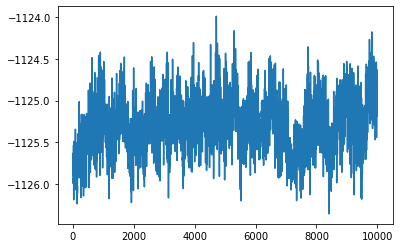

In [379]:
plt.plot(EnergyList)

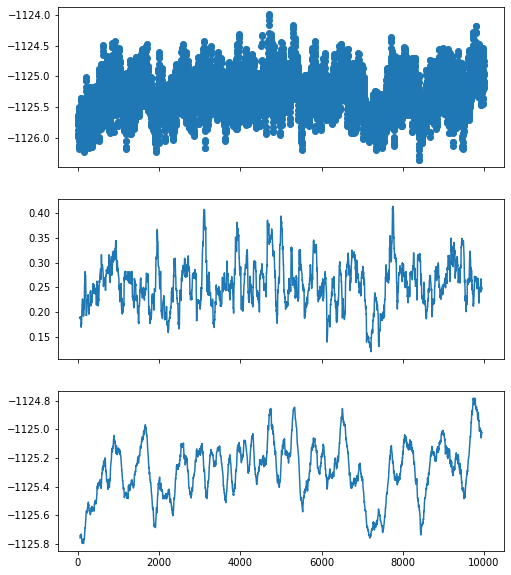

In [387]:
window = 100
rolling_stdevs = [np.std(EnergyList[i:i+window]) for i in range(len(EnergyList)-window+1)]
rolling_means = [np.mean(EnergyList[i:i+window]) for i in range(len(EnergyList)-window+1)]

fig, axs = plt.subplots(nrows=3, sharex =True, figsize=(8,10))

axs[0].plot(range(len(EnergyList)), EnergyList, "o")
axs[1].plot(np.arange(len(EnergyList)-window+1)+ (1 + window)/2, rolling_stdevs)
axs[2].plot(np.arange(len(EnergyList)-window+1)+ (1 + window)/2, rolling_means)

In [738]:
# This is my attempt at learning forces 
# Doesn't use LearnEnergyFromSoap because force learning is not yet implemented there (as of July 13th)
from sklearn.preprocessing import StandardScaler

collapsable=True

split_seed = 1
valid_split_seed = 1
training_frac = 0.9#my_n_train/my_n#0.9
valid_fract = 0.9

train_sps, test_sps, train_ens, test_ens,  train_pos, test_pos = train_test_split(SoapList, EnergyList, PosList,  random_state=split_seed, test_size=(1-training_frac))

# scaling
# ----------------------------------------------------------------------------------------
if collapsable:
    # Standardize input for improved learning. Fit is done only on training data, scaling is applied to 
    # both descriptors and their derivatives on training and test sets.
    # # pass with_mean=False to avoid breaking sparsity structure of data
    rescale_method = 1
    if rescale_method == 1:
        train_sps, test_sps = train_sps.reshape(-1, SoapList.shape[-1]), test_sps.reshape(-1, SoapList.shape[-1])
        soap_scaler = StandardScaler().fit(train_sps)
        train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
        train_sps, test_sps = train_sps.reshape(-1, *SoapList.shape[1:]), test_sps.reshape(-1, *SoapList.shape[1:])
    elif rescale_method == 2:
        train_sps, test_sps = train_sps.reshape(train_sps.shape[0], -1), test_sps.reshape(test_sps.shape[0], -1)
        soap_scaler = StandardScaler().fit(train_sps)
        train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
        train_sps, test_sps = train_sps.reshape(len(train_ens), SoapList.shape[1], -1), test_sps.reshape(len(test_ens), SoapList.shape[1], -1)

    # rescale energies
    ens_scaler = StandardScaler().fit(train_ens[:,None])
    train_ens, test_ens = ens_scaler.transform(train_ens[:,None])[:,0], ens_scaler.transform(test_ens[:,None])[:,0]
# ----------------------------------------------------------------------------------------

observation_index_points= tf.constant(train_sps, dtype=np.float64)
ens_observations = tf.constant(train_ens, dtype=np.float64)
index_points = tf.constant(test_sps, dtype=np.float64)
#
shuffle_seed = 1
batch_size = 3
batch_size_custom_mse_max = 100
learn_rate = 0.025
n_epochs = 10; n_epochs_nll = n_epochs; n_epochs_custom = n_epochs
iterations_per_epoch = int(len(train_ens)/batch_size)
#


# initialize kernels and model hyperparameters
# ----------------------------------------------------------------------------------------
if collapsable:
    noise_init = 1e-5; amp_init = 0.1; len_init = 100#42
    constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
    # nll (old approach)
    obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
    amplitude_nll = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_nll")
    len_scale_nll = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_nll")
    kernel_nll = tfk.ExponentiatedQuadratic(amplitude=amplitude_nll, length_scale=len_scale_nll, name="kernel_nll", feature_ndims=2)#SoapList.shape[1])
    trainable_variables_nll = [var.variables[0] for var in [amplitude_nll, len_scale_nll, obs_noise_nll]]
    # mostly mse, my custom approach
    # allows for forces to be considered during training
    obs_noise_custom = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_custom")
    amplitude_custom = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_custom")
    len_scale_custom = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_custom")
    kernel_custom = tfk.ExponentiatedQuadratic(amplitude=amplitude_custom, length_scale=len_scale_custom, name="kernel_custom", feature_ndims=2)#SoapList.shape[1])
    trainable_variables_custom = [var.variables[0] for var in [amplitude_custom, len_scale_custom, obs_noise_custom]]
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# old/nll approach
# ----------------------------------------------------------------------------------------
if False:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)

        return -gp.log_prob(observations)

    # Define mini-batch data iterator
    batches_nll = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )
    #

    optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

    for j in range(n_epochs):
        if not j % 3:
            print("Old learning, epoch {}".format(j))

        for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_nll, iterations_per_epoch)):
            with tf.GradientTape() as tape:
                loss_nll_i = loss_nll(index_points_i, ens_observations_i)
                loss_nll_i = tf.constant(loss_nll_i, dtype=np.float64)
            grads = tape.gradient(loss_nll_i, trainable_variables_nll)
            optimizer.apply_gradients(zip(grads, trainable_variables_nll))

    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    
        gprm_nll = tfd.GaussianProcessRegressionModel(
            kernel=kernel_nll,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_nll)
        predict_ens_nll = gprm_nll.mean()
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# custom/mostly mse approach
# ----------------------------------------------------------------------------------------
if collapsable:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_custom_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_custom, index_points=index_points, observation_noise_variance=obs_noise_custom)
        return -gp.log_prob(observations)

    @tf.function(autograph=False, experimental_compile=False)
    def mse(y_predict, y_true):
        return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

    #@tf.function(autograph=False, experimental_compile=False)
    def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
        mse1 = mse(y1_predict, y1_true)
#         print("mse1 = ", mse1)
        mse2 = mse(y2_predict, y2_true)
#         print("mse2 = ", mse2)
        return mse1 * weight1 + mse2 * weight2

    # batch it
    batches_custom = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )

    optimizer_custom = tf.keras.optimizers.Adam(learning_rate=learn_rate)

    # First run through the data a few times, minimizing nll because this is more robust to bad hyperparameter initialization
    n_epochs_custom_nll = 0
    for j in range(n_epochs_custom_nll):
        for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_custom, iterations_per_epoch)):
                with tf.GradientTape() as tape:
                    loss_custom_i = loss_custom_nll(index_points_i, ens_observations_i)
                    loss_custom_i = tf.constant(loss_custom_i, dtype=np.float64)
                grads = tape.gradient(loss_custom_i, trainable_variables_custom)
                optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))
    
    error_history = []
    for j in range(n_epochs_custom):
        if not j % 5:
            print("Custom learning, epoch {}".format(j))

        split_data_j = train_test_split(train_sps, train_ens, random_state =valid_split_seed+j, test_size=(1-valid_fract))
        train_sps_j, valid_sps_j, train_ens_j, valid_ens_j = split_data_j
        observation_index_points_j = tf.constant(train_sps_j, dtype=np.float64)
        ens_observations_j = tf.constant(train_ens_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_sps_j, dtype=np.float64)
        heldout_ens_observations_j = tf.constant(valid_ens_j, dtype=np.float64)


        if len(train_sps_j) < batch_size_custom_mse_max:
            iterations_per_epoch_custom = 1
            batch_size_custom = len(train_sps_j)
        else:
            iterations_per_epoch_custom = int(np.ceil(len(train_sps_j)/batch_size_custom_mse_max))
            batch_size_custom = int(np.ceil(len(train_sps_j)/iterations_per_epoch_custom))

        batches_custom_j = (
            tf.data.Dataset.from_tensor_slices((observation_index_points_j, ens_observations_j)) # frcs_observations_j_i might be extraneous
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size_custom)
        )
        error_j = 0
        for i, (index_points_j_i, ens_observations_j_i) in enumerate(islice(batches_custom_j, iterations_per_epoch_custom)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
                    tape_d_ens.watch(heldout_index_points_j)    
                    gprm_custom_j_i = tfd.GaussianProcessRegressionModel(
                        kernel = kernel_custom,
                        index_points = heldout_index_points_j,
                        observation_index_points = index_points_j_i,
                        observations = ens_observations_j_i,
                        observation_noise_variance = obs_noise_custom)
                    predict_ens_j_i = gprm_custom_j_i.sample()
                error_custom_j_i = mse(predict_ens_j_i, heldout_ens_observations_j)
                error_j += error_custom_j_i


            grads = tape.gradient(error_custom_j_i, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))
        interpretable_error_j = np.sqrt(error_j/iterations_per_epoch_custom)
        error_history.append(interpretable_error_j)
        print("Error {} = {:.2f}".format(j, interpretable_error_j))


    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    

        gprm_custom = tfd.GaussianProcessRegressionModel(
            kernel=kernel_custom,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_custom)

        predict_ens_custom = gprm_custom.mean()
    
    test_ens_rescaled = ens_scaler.inverse_transform(test_ens)
    
    predict_ens_custom_rescaled = ens_scaler.inverse_transform(predict_ens_custom)
        
    performance_Graphene_by_n[my_n_train] = np.max(np.abs(ens_scaler.inverse_transform(test_ens) - ens_scaler.inverse_transform(predict_ens_custom)))
# ----------------------------------------------------------------------------------------


Custom learning, epoch 0
Error 0 = 0.06
Error 1 = 0.05
Error 2 = 0.03
Error 3 = 0.05
Error 4 = 0.05
Custom learning, epoch 5
Error 5 = 0.04
Error 6 = 0.03
Error 7 = 0.03
Error 8 = 0.02
Error 9 = 0.02


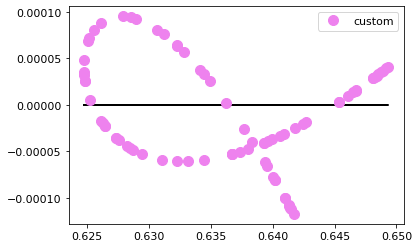

In [372]:
plot_custom = True; plot_nll = False
plt.plot(test_ens_rescaled, np.zeros(len(test_ens)), "-", c="k")
if plot_custom:
    plt.plot(test_ens_rescaled, predict_ens_custom_rescaled-test_ens_rescaled ,"o", label="custom", c="violet", ms=10)
if plot_nll:
    plt.plot(test_ens_rescaled, predict_ens_nll_rescaled-test_ens_rescaled ,"o", label="nll", c="lime", ms=5)
plt.legend()


In [740]:
predict_ens_custom_rescaled1 = predict_ens_custom_rescaled.copy()

In [602]:
predict_ens_custom_rescaled1 - predict_ens_custom_rescaled2

array([-5.05853027e-03, -6.82653784e-05,  1.74115710e-03,  1.67828411e-04,
       -1.17465757e-03, -1.68600097e-03,  3.54339443e-05,  9.41300341e-05,
       -1.70810897e-03, -2.71952682e-03])

In [460]:
#performance_Graphene_by_n = {}

In [372]:
performance_Graphene_by_n

{30: 0.039455924021694955,
 50: 0.025520192534258967,
 60: 0.05015260878803929,
 90: 0.02628695509292811,
 100: 0.012542909998046525,
 200: 0.016431664258334422,
 300: 0.010318825536614895,
 500: 0.007422881928278002,
 150: 0.016834547242751796,
 900: 0.01562840400129062,
 700: 0.011335636350395362,
 250: 0.012518518815113566,
 1200: 0.012184416445052193,
 1000: 0.017007521724281105,
 1500: 0.015366629510708663,
 1100: 0.009441366010833008,
 400: 0.010275217199023245,
 600: 0.011123969460413718,
 800: 0.010949366652766912,
 2000: 0.019939079705636686,
 225: 0.006798546424988672,
 275: 0.010863128772143682,
 325: 0.007438278799327236,
 350: 0.01214594757220766,
 375: 0.012026006968198999,
 425: 0.00861313098721439,
 450: 0.015816443732319385,
 475: 0.019517097873631428,
 525: 0.007056522666516685,
 550: 0.012612630380317569,
 575: 0.011025575577605196,
 625: 0.013882095822964402,
 675: 0.009054737313363148,
 725: 0.014970176715223715,
 750: 0.012289034279092448,
 775: 0.0148924661887122

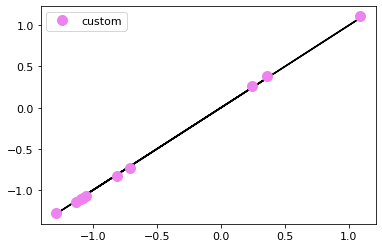

In [741]:
plot_custom = True; plot_nll = False
plt.plot(test_ens, test_ens, "-", c="k")
if plot_custom:
    plt.plot(test_ens, predict_ens_custom,"o", label="custom", c="violet", ms=10)
if plot_nll:
    plt.plot(test_ens, predict_ens_nll,"o", label="nll", c="lime", ms=5)
plt.legend()

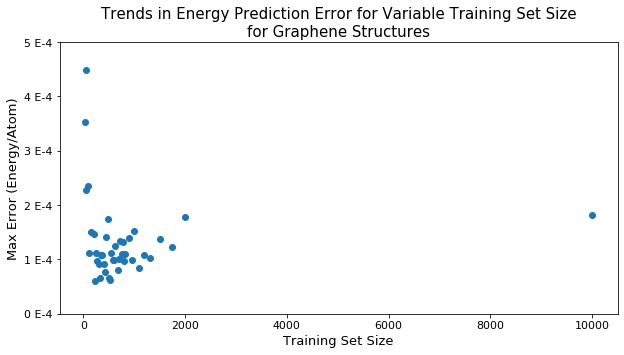

In [455]:
fig, ax = plt.subplots(figsize=(10,5))
ns = list(performance_Graphene_by_n.keys())
errs_per_atom = [err/112 for err in performance_Graphene_by_n.values()] # change hard coded atom number
ax.plot(ns, errs_per_atom, "o")
ax.set_xlabel("Training Set Size")
ax.set_ylabel("Max Error (Energy/Atom)")
tick_step = 10**(np.round(np.log10(max(errs_per_atom)))-1)
n_ticks = int(max(errs_per_atom)/tick_step) + 1
ticks = [float(tick_step)*i for i in range(n_ticks + 1)]
ax.set_yticks(ticks)
ax.set_yticklabels(['{:.0f} E-4'.format(t*10000) for t in ticks])
plt.title("Trends in Energy Prediction Error for Variable Training Set Size\nfor Graphene Structures")
plt.savefig('../media/Trends_in_Energy_Prediction_Error_for_Variable_Training_Set_Size_for_Graphene_Structures.png')


---

# Forces and energies

In [472]:
# Collect input data for soap->energy/forces learning model without looping
# Unlike above (in the Plottable_Model_Errors cell) I am collecting forces here as well

# MD parameters
my_element = "O"
my_temp=300
my_n = 2000
my_calc = "EMT"
my_md_seed = 1

# SOAP parameters
get_local_descriptors = True
my_nmax=8
my_lmax=8

#from Molecular_Dynamics import make_diatomic
#AtomsList = [make_diatomic(element = my_element, verbose=False, bond_length=L, calc_type=my_calc) for L in np.linspace(.6,1.8, my_n)]
#AtomsList = generate_md_traj(from_diatomic=True, element=my_element, temperature=my_temp, nsteps=my_n, md_type = "VelocityVerlet", calc_type=my_calc, md_seed= my_md_seed)
#AtomsList = read("../data/ManyGraphenes.gz", ":{}".format(my_n))
AtomsList = read("../data/distorted_propanol.extxyz.gz", ":{}".format(my_n))
PosList =  np.array([atoms.positions for atoms in AtomsList])#[:,1]# only get position of one atom while we are doing global soap
#AveragePosition = np.mean(PosList.reshape(-1, PosList.shape[-1]), axis = 0)
#SoapCenterPositions = AveragePosition[None, :].repeat(PosList.shape[0], axis=0)[:,None,:]
#SoapCenterPositions = np.array([AveragePosition, [0,0,0]])[None,:].repeat(PosList.shape[0], axis=0)

EnergyList = np.array([atom.get_potential_energy() for atom in AtomsList], dtype=np.float64) # I had to change this to potential energy or the derivative doesn't work
ForceList = np.array([atom.get_forces() for atom in AtomsList], dtype=np.float64)#[:,1] # only get force of one atom while we are doing global soap
SoapDerivativeList, SoapList = get_dscribe_descriptors(AtomsList, species=np.unique(AtomsList[0].get_chemical_symbols()), attach=True, 
                                                       is_global= not get_local_descriptors, return_derivatives=True, nmax=my_nmax, lmax=my_lmax)#, positions = SoapCenterPositions)


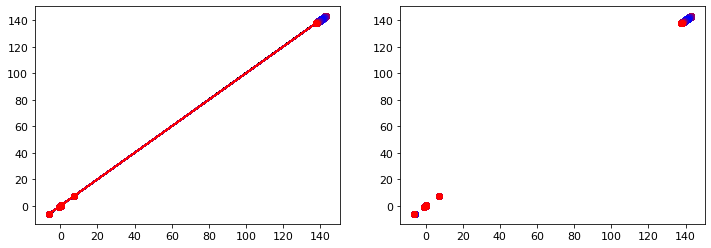

In [441]:
scaled_ens = (EnergyList - np.min(EnergyList))/np.ptp(EnergyList)

fig, axs = plt.subplots(ncols = 2, figsize=(12,4))
for i in range(len(SoapList)):
    sp = SoapList[i]
    en = scaled_ens[i]
    axs[0].plot(sp[0], sp[1], "-o", c= [en, 0, 1-en] )#c= [en] *3 )
    axs[1].plot(sp[0], sp[1], "o", c= [en, 0, 1-en] )#c= [en] *3 )
    


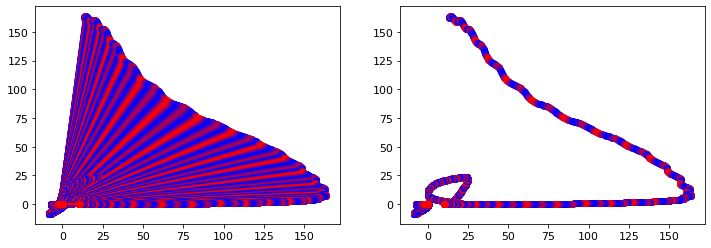

In [438]:
scaled_ens = (EnergyList - np.min(EnergyList))/np.ptp(EnergyList)

fig, axs = plt.subplots(ncols = 2, figsize=(12,4))
for i in range(len(SoapList)):
    sp = SoapList[i]
    en = scaled_ens[i]
    axs[0].plot(sp[0], sp[1], "-o", c= [en, 0, 1-en] )#c= [en] *3 )
    axs[1].plot(sp[0], sp[1], "o", c= [en, 0, 1-en] )#c= [en] *3 )
    


In [473]:
# This is my attempt at learning forces 
# Doesn't use LearnEnergyFromSoap because force learning is not yet implemented there (as of July 13th)

split_seed = 1
valid_split_seed = 1
training_frac = 0.9
valid_fract = 0.9

split_data = train_test_split(SoapList, SoapDerivativeList, EnergyList, ForceList, PosList, range(len(SoapList)), 
                              random_state=split_seed, test_size=(1-training_frac))
train_sps, test_sps, train_d_sps, test_d_sps, train_ens, test_ens, train_frcs, test_frcs, train_pos, test_pos, train_indices, test_indices = split_data


train_sps, test_sps = train_sps.reshape(-1, SoapList.shape[-1]), test_sps.reshape(-1, SoapList.shape[-1])
soap_scaler = StandardScaler().fit(train_sps)
train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
train_sps, test_sps = train_sps.reshape(-1, *SoapList.shape[1:]), test_sps.reshape(-1, *SoapList.shape[1:])
test_d_sps /= soap_scaler.scale_[None, None, None, None, :]
train_d_sps /= soap_scaler.scale_[None, None, None, None, :]


ens_scaler = StandardScaler().fit(train_ens[:,None])
train_ens, test_ens = ens_scaler.transform(train_ens[:,None])[:,0], ens_scaler.transform(test_ens[:,None])[:,0]
train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

# # Should the variance be calculated before the rescaling?
ens_var = train_ens.var(); frcs_var = train_frcs.var()

#observation_index_points= tf.constant(np.array(train_pos), dtype=np.float64)
observation_index_points= tf.constant(train_sps, dtype=np.float64)
ens_observations = tf.constant(train_ens, dtype=np.float64)
frcs_observations = tf.constant(train_frcs, dtype=np.float64)
#index_points = tf.constant(np.array(test_pos), dtype=np.float64)
index_points = tf.constant(test_sps, dtype=np.float64)
#
shuffle_seed = 1
batch_size = 3
batch_size_custom_mse_max = 100
learn_rate = 0.025
n_epochs_max = 10; n_epochs_max_nll = n_epochs_max; n_epochs_max_custom = n_epochs_max
iterations_per_epoch = int(len(train_ens)/batch_size)
#


# initialize kernels and model hyperparameters
# ----------------------------------------------------------------------------------------
noise_init = 1e-5; amp_init = 0.1; len_init = 100 * train_sps.shape[1] * train_sps.shape[2]/np.sum(soap_scaler.scale_ )
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
# nll (old approach)
obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
amplitude_nll = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_nll")
len_scale_nll = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_nll")
kernel_nll = tfk.ExponentiatedQuadratic(amplitude=amplitude_nll, length_scale=len_scale_nll, name="kernel_nll", feature_ndims=1)#SoapList.shape[1])
trainable_variables_nll = [var.variables[0] for var in [amplitude_nll, len_scale_nll, obs_noise_nll]]
# mostly mse, my custom approach
# allows for forces to be considered during training
obs_noise_custom = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_custom")
amplitude_custom = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_custom")
len_scale_custom = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_custom")
kernel_custom = tfk.ExponentiatedQuadratic(amplitude=amplitude_custom, length_scale=len_scale_custom, name="kernel_custom", feature_ndims=2)
trainable_variables_custom = [var.variables[0] for var in [amplitude_custom, len_scale_custom, obs_noise_custom]]
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# old/nll approach
# ----------------------------------------------------------------------------------------
@tf.function(autograph=False, experimental_compile=False)
def loss_nll(index_points, observations):
    gp = tfd.GaussianProcess(kernel=kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)
    print("index_points.shape = ", index_points.shape)
    print("observations.shape = ", observations.shape)
    return -gp.log_prob(observations)

# Define mini-batch data iterator
batches_nll = (
    tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
    .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
    .repeat(count=None)
    .batch(batch_size)
)
#

optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

if False:
    for j in range(n_epochs_max):

        loss_nll_j = 0
        for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_nll, iterations_per_epoch)):
            with tf.GradientTape() as tape:
                loss_nll_i = loss_nll(index_points_i, ens_observations_i)
                loss_nll_i = tf.constant(loss_nll_i, dtype=np.float64)
                loss_nll_j += loss_nll_i
            grads = tape.gradient(loss_nll_i, trainable_variables_nll)
            optimizer.apply_gradients(zip(grads, trainable_variables_nll))
        if not j % 4:
            print("Old learning, epoch {} loss: {:10.0f}".format(j, loss_nll_j))
            print([(v.name, 2.71828**v.numpy()) for v in trainable_variables_nll])

    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    
        gprm_nll = tfd.GaussianProcessRegressionModel(
            kernel=kernel_nll,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_nll)
        print(index_points.shape)
        print(observation_index_points.shape)
        print(ens_observations.shape)
        predict_ens_nll = gprm_nll.mean()

    predict_d_ens_nll = tape_d_ens.gradient(predict_ens_nll, index_points)
    #print(predict_d_ens_nll[:1])
    #predict_d_ens_nll = predict_d_ens_nll[:,0,:]
    #print(predict_d_ens_nll[:1])

    print("predict_d_ens_nll.shape =", predict_d_ens_nll.shape)
    print("test_d_sps.shape = ", test_d_sps.shape )
    print("\ntest_d_sps[0][:,:,0] = \n", test_d_sps[0][:,:,0])
    print("\npredict_d_ens_nll[0] = \n", predict_d_ens_nll[0])
    predict_frcs_nll = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_nll)#[:,1] # only get force of one atom while we are doing global soap
    print("\npredict_frcs_nll[0][:,0] = \n", predict_frcs_nll[0][:,0])

    # predict_d_ens_nll.shape = (75, 2, 18)
    # test_d_sps.shape =  (75, 2, 2, 3, 18)
    #     print("test_d_sps", test_d_sps)
    #     print("predict_d_ens_nll", predict_d_ens_nll)
    #     print("predict_frcs_nll", -1*np.einsum('ijkl,il->ijk', test_d_sps, predict_d_ens_nll))
    # ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# custom/mostly mse approach
# ----------------------------------------------------------------------------------------
if True:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_custom_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_custom, index_points=index_points, observation_noise_variance=obs_noise_custom)
        return -gp.log_prob(observations)

    @tf.function(autograph=False, experimental_compile=False)
    def mse(y_predict, y_true):
        return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

    #@tf.function(autograph=False, experimental_compile=False)
    def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
        mse1 = mse(y1_predict, y1_true)
        #print("mse1 = ", mse1 / weight1)
        mse2 = mse(y2_predict, y2_true)*3
        #mse2 = tf.math.reduce_mean(tf.math.reduce_sum(tf.math.squared_difference(y_predict, y_true), axis = 2))
        #print("mse2 = ", mse2 / weight2)
        return mse1 * weight1 + mse2 * weight2

    # batch it
    batches_custom = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations, frcs_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )

    optimizer_custom = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    
    # ----------------- see if this works -----------------
    print(observation_index_points.shape)
    print(ens_observations.shape)
    loss_custom_nll(observation_index_points, ens_observations)
    # 
    

    # First run through the data a few times, minimizing nll because this is more robust to bad hyperparameter initialization
    n_epochs_max_custom_nll = 0
    for j in range(n_epochs_max_custom_nll):
        for i, (index_points_i, ens_observations_i, ignore_forces_here) in enumerate(islice(batches_custom, iterations_per_epoch)):
                with tf.GradientTape() as tape:
                    loss_custom_i = loss_custom_nll(index_points_i, ens_observations_i)
                    loss_custom_i = tf.constant(loss_custom_i, dtype=np.float64)
                grads = tape.gradient(loss_custom_i, trainable_variables_custom)
                optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))

    for j in range(n_epochs_max_custom):
        
        if not j % 1:
            print("Custom learning, epoch {}".format(j+1))
            print([" {} = {:.2e} ".format(var.name, np.exp(var.numpy())) for var in trainable_variables_custom])

        split_data_j = train_test_split(train_sps, train_ens, train_d_sps, train_frcs, random_state =valid_split_seed+j, test_size=(1-valid_fract))
        train_sps_j, valid_sps_j, train_ens_j, valid_ens_j, train_d_sps_j, valid_d_sps_j, train_frcs_j, valid_frcs_j = split_data_j
        observation_index_points_j = tf.constant(train_sps_j, dtype=np.float64)
        ens_observations_j = tf.constant(train_ens_j, dtype=np.float64)
        d_sps_observations_j = tf.constant(train_d_sps_j, dtype=np.float64)
        frcs_observations_j = tf.constant(train_frcs_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_sps_j, dtype=np.float64)
        heldout_ens_observations_j = tf.constant(valid_ens_j, dtype=np.float64)
        heldout_d_sps_observations_j = tf.constant(valid_d_sps_j, dtype=np.float64)
        heldout_frcs_observations_j = tf.constant(valid_frcs_j, dtype=np.float64)

        if len(train_sps_j) < batch_size_custom_mse_max:
            iterations_per_epoch_custom = 1
            batch_size_custom = len(train_sps_j)
        else:
            iterations_per_epoch_custom = int(np.ceil(len(train_sps_j)/batch_size_custom_mse_max))
            batch_size_custom = int(np.ceil(len(train_sps_j)/iterations_per_epoch_custom))

        batches_custom_j = (
            tf.data.Dataset.from_tensor_slices((observation_index_points_j, ens_observations_j, d_sps_observations_j, frcs_observations_j)) # frcs_observations_j_i might be extraneous
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size_custom)
        )
        for i, (index_points_j_i, ens_observations_j_i, d_sps_observations_j_i, frcs_observations_j_i) \
                in enumerate(islice(batches_custom_j, iterations_per_epoch_custom)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
                    tape_d_ens.watch(heldout_index_points_j)    
                    gprm_custom_j_i = tfd.GaussianProcessRegressionModel(
                        kernel = kernel_custom,
                        index_points = heldout_index_points_j,
                        observation_index_points = index_points_j_i,
                        observations = ens_observations_j_i,
                        observation_noise_variance = obs_noise_custom)
                    predict_ens_j_i = gprm_custom_j_i.sample()
                predict_d_ens_j_i = tape_d_ens.gradient(predict_ens_j_i, heldout_index_points_j)
                #predict_frcs_j_i = -predict_d_ens_j_i
                predict_frcs_j_i = -1*np.einsum('imjkl,iml->ijk', heldout_d_sps_observations_j, predict_d_ens_j_i)#[:,1] # only get force of one atom while we are doing global soap
                error_custom_j_i = mse_2factor(predict_ens_j_i, heldout_ens_observations_j, 1/ens_var,
                                               predict_frcs_j_i, heldout_frcs_observations_j, 1/frcs_var)
#                 print("predict_ens_j_i = ", predict_ens_j_i)
#                 print("heldout_ens_observations_j = ", heldout_ens_observations_j)
#                 print("1/ens_var = ", 1/ens_var)
#                 print("predict_frcs_j_i = ", predict_frcs_j_i)
#                 print("heldout_frcs_observations_j = ", heldout_frcs_observations_j)
#                 print("1/frcs_var = ",1/frcs_var)
#                 print("error value is ", error_custom_j_i)


            grads = tape.gradient(error_custom_j_i, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))


    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    

        gprm_custom = tfd.GaussianProcessRegressionModel(
            kernel=kernel_custom,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_custom)

        predict_ens_custom = gprm_custom.mean()

    predict_d_ens_custom = tape_d_ens.gradient(predict_ens_custom, index_points)
    #predict_frcs_custom = -predict_d_ens_custom.numpy()
    predict_frcs_custom = -1*np.einsum('imjkl,iml->ijk', test_d_sps, predict_d_ens_custom)#[:,1] # only get force of one atom while we are doing global soap

    test_ens_rescaled = ens_scaler.inverse_transform(test_ens)
    predict_ens_custom_rescaled = ens_scaler.inverse_transform(predict_ens_custom)
# -------------------------------------------------------------------



(1800, 10, 2700)
(1800,)
Custom learning, epoch 1
[' amplitude_custom:0 = 1.00e-01 ', ' len_scale_custom:0 = 3.01e+03 ', ' noise_custom:0 = 1.00e-05 ']
Custom learning, epoch 2
[' amplitude_custom:0 = 1.43e-01 ', ' len_scale_custom:0 = 2.10e+03 ', ' noise_custom:0 = 7.00e-06 ']
Custom learning, epoch 3
[' amplitude_custom:0 = 1.73e-01 ', ' len_scale_custom:0 = 1.74e+03 ', ' noise_custom:0 = 5.81e-06 ']
Custom learning, epoch 4
[' amplitude_custom:0 = 1.98e-01 ', ' len_scale_custom:0 = 1.51e+03 ', ' noise_custom:0 = 5.11e-06 ']
Custom learning, epoch 5
[' amplitude_custom:0 = 2.33e-01 ', ' len_scale_custom:0 = 1.27e+03 ', ' noise_custom:0 = 4.38e-06 ']
Custom learning, epoch 6
[' amplitude_custom:0 = 2.65e-01 ', ' len_scale_custom:0 = 1.10e+03 ', ' noise_custom:0 = 3.89e-06 ']
Custom learning, epoch 7
[' amplitude_custom:0 = 2.86e-01 ', ' len_scale_custom:0 = 1.00e+03 ', ' noise_custom:0 = 3.63e-06 ']
Custom learning, epoch 8
[' amplitude_custom:0 = 3.00e-01 ', ' len_scale_custom:0 = 9.

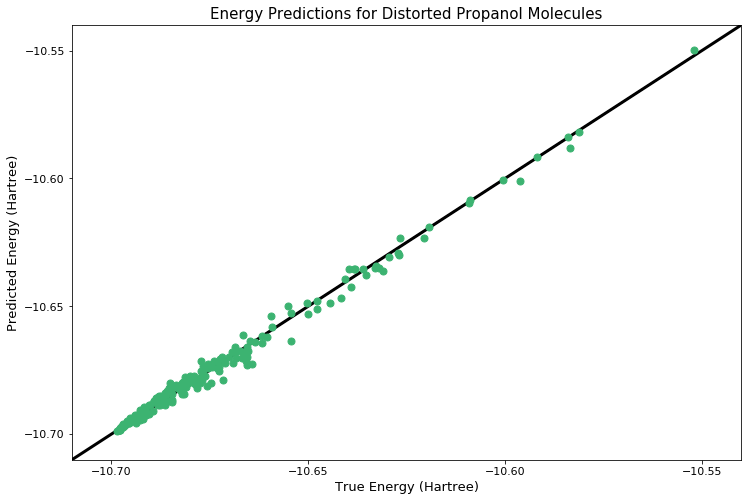

In [484]:
fig, ax = plt.subplots(figsize=(12,8))


import matplotlib
matplotlib.rc('font', size=20)
ticks = [-10.50, -10.55, -10.60, -10.65, -10.70, -10.75]
plt.plot(ticks, ticks, c="k", lw=3)
lower_lim = -10.71
upper_lim = -10.54
plt.xticks(ticks); plt.xlim(lower_lim, upper_lim)
plt.yticks(ticks); plt.ylim(lower_lim, upper_lim)
plt.xlabel("True Energy (Hartree)")
plt.ylabel("Predicted Energy (Hartree)")
plt.title("Energy Predictions for Distorted Propanol Molecules")

plot_custom = True; plot_nll = False
plt.plot(test_ens_rescaled/27.2114, test_ens_rescaled/27.2114, "-", c="k")
if plot_custom:
    plt.plot(test_ens_rescaled/27.2114, predict_ens_custom_rescaled/27.2114 ,"o", label="custom", c="mediumseagreen", ms=7)
if plot_nll:
    plt.plot(test_ens, predict_ens_nll ,"o", label="nll", c="lime", ms=5)
#plt.legend()

Text(0.5, 1.0, 'Error Histogram for Energy Predictions for Distorted Propanol Molecules')

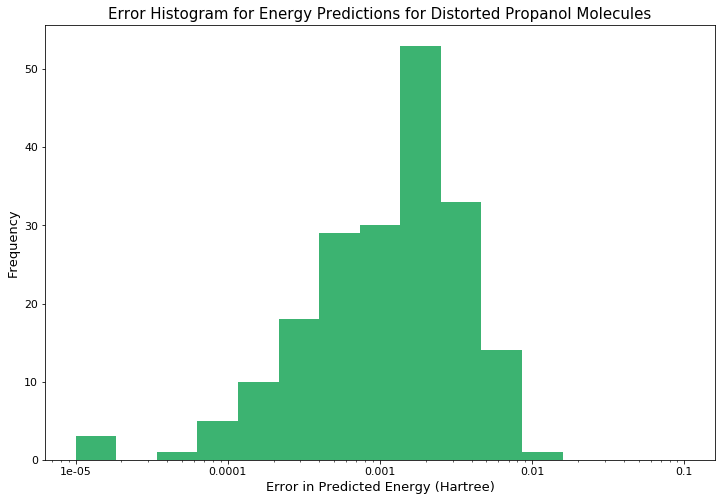

In [487]:
fig, ax = plt.subplots(figsize=(12,8))
errors = abs(predict_ens_custom_rescaled-test_ens_rescaled)/27.2114
logbins = np.logspace(-5,-1,16)
logticklabels = np.logspace(-5,-1,5)
plt.hist(errors, bins=logbins, color="mediumseagreen")
plt.xscale('log')
plt.xticks(logticklabels, labels=logticklabels)
plt.xlabel("Error in Predicted Energy (Hartree)")
plt.ylabel("Frequency")
plt.title("Error Histogram for Energy Predictions for Distorted Propanol Molecules")


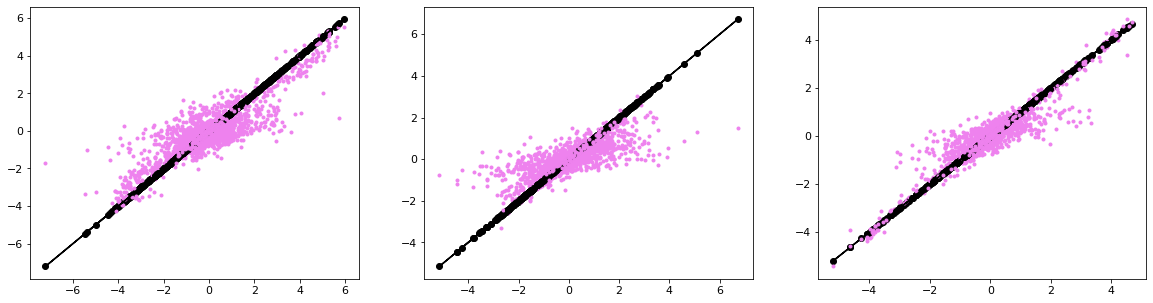

In [475]:

rescaled_test_frcs = test_frcs * ens_scaler.scale_
if plot_custom:
    rescaled_predict_frcs_custom =  predict_frcs_custom * ens_scaler.scale_
if plot_nll:
    rescaled_predict_frcs_nll = predict_frcs_nll * ens_scaler.scale_



fig, axs = plt.subplots(ncols=3, figsize=(20,5))
components = ["x", "y", "z"]

counts = [0,0,0]

for i in range(3):
    for j in range(rescaled_test_frcs.shape[1]):
        axs[i].plot(rescaled_test_frcs[:,j,i], rescaled_test_frcs[:,j,i], "o-", c="k")
        if plot_custom:
            axs[i].plot(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_custom[:,j,i], "o", label="custom", c="violet", ms=3)
            counts[i] +=1
#             try:
#                 print(i,j)
#                 m, b = np.polyfit(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_custom[:,j,i], 1)
#                 r2 = np.corrcoef(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_custom[:,j,i])[0,1]
#                 print("Least-squares regresion for F{}({}) produces the line line m {}+b with m = {:.5f} and b = {:.5f} which has r2 = {:.5f} ".format(components[i],components[i],components[i],m,b, r2))
#             except:
#                 pass        
        if plot_nll:
            axs[i].plot(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_nll[:,j,i], "o", label="nll", c="lime", ms=5)
    #axs[i].legend()

---

debugging the forces  
it works now IF you don't send descriptor positions AND you use attach = True

In [ ]:
# Collect input data for soap->energy/forces learning model without looping
# Unlike above (in the Plottable_Model_Errors cell) I am collecting forces here as well

# MD parameters
my_element = "O"
my_temp=300
my_n = 200
my_calc = "EMT"
my_md_seed = 1

# SOAP parameters
get_local_descriptors = True
my_nmax=5
my_lmax=5

from Molecular_Dynamics import make_diatomic
#AtomsList = [make_diatomic(element = my_element, verbose=False, bond_length=L, calc_type=my_calc) for L in np.linspace(.8,1.2, my_n)]
#AtomsList = generate_md_traj(from_diatomic=True, element=my_element, temperature=my_temp, nsteps=my_n, md_type = "VelocityVerlet", calc_type=my_calc, md_seed= my_md_seed)
#AtomsList = read("../data/ManyGraphenes.gz", ":{}".format(my_n))
AtomsList = read("../data/distorted_propanol.extxyz.gz", ":{}".format(my_n))
PosList =  np.array([atoms.positions for atoms in AtomsList])#[:,1]# only get position of one atom while we are doing global soap

EnergyList = np.array([atom.get_potential_energy() for atom in AtomsList], dtype=np.float64) # I had to change this to potential energy or the derivative doesn't work
ForceList = np.array([atom.get_forces() for atom in AtomsList], dtype=np.float64)#[:,1] # only get force of one atom while we are doing global soap
SoapDerivativeList, SoapList = get_dscribe_descriptors(AtomsList, species=np.unique(AtomsList[0].get_chemical_symbols()), attach=True, is_global= not get_local_descriptors, return_derivatives=True, nmax=my_nmax, lmax=my_lmax)
#SoapDerivativeList = SoapDerivativeList[:,0,:,:,:]; SoapList = SoapList[:,0,:] # Using global soap right now so we can remove the local descriptor index
#SoapList = SoapList[:,0,:] 
#SoapList = SoapList.reshape(len(SoapList),-1)

In [8]:
SoapDerivativeList[0,0,0]

array([[0.],
       [0.],
       [0.]])

In [18]:
print([type(z) for z in SoapDerivativeList[0,0,0,:,0]])

[<class 'numpy.float64'>, <class 'numpy.float64'>, <class 'numpy.float64'>]


In [53]:
from ase import build
C = build.molecule("C")
a,b =get_dscribe_descriptors(C, species=["C"], is_global= False, return_derivatives=True, nmax=1, lmax=0, attach=False, positions = [[[0.0,0.0,0.0]]])#, is_periodic=True)
print(a, np.max(a)*1e10)
print(b)

[[[[[0.]
    [0.]
    [0.]]]]] 0.0
[[[6.25043443]]]


In [82]:
from ase import build
C = build.molecule("C")
a,b =get_dscribe_descriptors(C, species=["C"], is_global= False, return_derivatives=True, nmax=1, lmax=0, attach=False, positions = [[[0,0,0]]])#, is_periodic=True)
print(a, np.max(a)*1e10)
print(b)

[[[[[0.]
    [0.]
    [0.]]]]] 0.0
[[[6.25043443]]]


In [261]:
from dscribe.descriptors import SOAP
from ase import build
C = build.molecule("C")
soap = SOAP(average="off",  species=["C"], periodic=False, rcut=3.2, nmax=1, lmax=7, rbf="gto")
a, b = soap.derivatives(C, attach=False, method="auto")#, positions = [[0.0,0.0,0.0]])
print(a, np.max(a)*1e10)
print(b)

[[[[0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0. 0. 0. 0.]]]] 0.0
[[6.25043443 0.         0.         0.         0.         0.
  0.         0.        ]]


Atoms(symbols='H2', pbc=False, calculator=EMT(...))

In [263]:
from dscribe.descriptors import SOAP
H2 = make_diatomic(element = "H", verbose=False, bond_length=4.3)#build.molecule("H2")
print(H2.positions)
soap = SOAP(average="off",  species=["H"], periodic=False, rcut=1.1, nmax=1, lmax=0, rbf="gto")
a, b = soap.derivatives(H2, attach=False)#, positions = H2.positions)
nonzero_min =np.min(np.abs(np.ma.masked_equal(a, 0, copy=True)))
print(a, nonzero_min)
print(b)

[[ 0.    0.   -2.15]
 [ 0.    0.    2.15]]
[[[[ 0.        ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [-0.00903833]]]


 [[[ 0.        ]
   [ 0.        ]
   [ 0.00903833]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]]]] 0.009038327849984557
[[6.25268831]
 [6.25268831]]


In [140]:
H2.positions.shape

(2, 3)

In [131]:
from dscribe.descriptors import SOAP
H2 = build.molecule("H2")
soap = SOAP(average="off",  species=["H"], periodic=False, rcut=3.2, nmax=1, lmax=0, rbf="gto")
a, b = soap.derivatives(H2, attach=False)#, positions = [[0.0,0.0,0.0]])
print(a)
print(b)

[[[[  0.        ]
   [  0.        ]
   [  0.        ]]

  [[  0.        ]
   [  0.        ]
   [ 11.84697057]]]


 [[[  0.        ]
   [  0.        ]
   [-11.84697057]]

  [[  0.        ]
   [  0.        ]
   [  0.        ]]]]
[[19.71902403]
 [19.71902403]]


In [62]:
from ase import build
C = build.molecule("C")
a,b =get_dscribe_descriptors(C, species=["C"], is_global= False, return_derivatives=True, nmax=1, lmax=0, attach=True, positions = [[[0.0,0.0,0.0]]])#, is_periodic=True)
print(a, np.max(a)*1e10)
print(b)

[[[[[0.]
    [0.]
    [0.]]]]] 0.0
[[[6.25043443]]]


In [83]:
from ase import build
C = build.molecule("C")
a,b =get_dscribe_descriptors(C, species=["C"], is_global= False, return_derivatives=True, nmax=1, lmax=0, attach=True, positions = [[[0,0,0]]])#, is_periodic=True)
print(a, np.max(a)*1e10)
print(b)

[[[[[0.]
    [0.]
    [0.]]]]] 0.0
[[[6.25043443]]]


In [102]:
# This is my attempt at learning forces 
# Doesn't use LearnEnergyFromSoap because force learning is not yet implemented there (as of July 13th)

split_seed = 1
valid_split_seed = 1
training_frac = 0.9
valid_fract = 0.9

split_data = train_test_split(SoapList, SoapDerivativeList, EnergyList, ForceList, PosList, range(len(SoapList)), 
                              random_state=split_seed, test_size=(1-training_frac))
train_sps, test_sps, train_d_sps, test_d_sps, train_ens, test_ens, train_frcs, test_frcs, train_pos, test_pos, train_indices, test_indices = split_data

# scaling
# Standardize input for improved learning. Fit is done only on training data, scaling is applied to 
# both descriptors and their derivatives on training and test sets.
# # pass with_mean=False to avoid breaking sparsity structure of data
# soap_scaler = StandardScaler().fit(train_sps.reshape(-1,train_sps.shape[-1]))
# train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
# train_d_sps = train_d_sps / soap_scaler.scale_[None, None, None, :]
# test_d_sps = test_d_sps / soap_scaler.scale_[None, None, None, :]

train_sps, test_sps = train_sps.reshape(-1, SoapList.shape[-1]), test_sps.reshape(-1, SoapList.shape[-1])
soap_scaler = StandardScaler().fit(train_sps)
train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
train_sps, test_sps = train_sps.reshape(-1, *SoapList.shape[1:]), test_sps.reshape(-1, *SoapList.shape[1:])
test_d_sps /= soap_scaler.scale_[None, None, None, None, :]
train_d_sps /= soap_scaler.scale_[None, None, None, None, :]

# # Should I also rescale energies and/or forces?
# # For now I will
# ens_scaler = StandardScaler().fit(train_ens)
# train_ens, test_ens = ens_scaler.transform(train_ens), ens_scaler.transform(test_ens)
# train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
# test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

ens_scaler = StandardScaler().fit(train_ens[:,None])
train_ens, test_ens = ens_scaler.transform(train_ens[:,None])[:,0], ens_scaler.transform(test_ens[:,None])[:,0]
train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

# # Should the variance be calculated before the rescaling?
ens_var = train_ens.var(); frcs_var = train_frcs.var()

#observation_index_points= tf.constant(np.array(train_pos), dtype=np.float64)
observation_index_points= tf.constant(train_sps, dtype=np.float64)
ens_observations = tf.constant(train_ens, dtype=np.float64)
frcs_observations = tf.constant(train_frcs, dtype=np.float64)
#index_points = tf.constant(np.array(test_pos), dtype=np.float64)
index_points = tf.constant(test_sps, dtype=np.float64)
#
shuffle_seed = 1
batch_size = 3
batch_size_custom_mse_max = 100
learn_rate = 0.025
n_epochs = 20; n_epochs_nll = n_epochs; n_epochs_custom = n_epochs
iterations_per_epoch = int(len(train_ens)/batch_size)
#


# initialize kernels and model hyperparameters
# ----------------------------------------------------------------------------------------
noise_init = 1e-5; amp_init = 0.1; len_init = 100
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
# nll (old approach)
obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
amplitude_nll = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_nll")
len_scale_nll = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_nll")
kernel_nll = tfk.ExponentiatedQuadratic(amplitude=amplitude_nll, length_scale=len_scale_nll, name="kernel_nll", feature_ndims=1)#SoapList.shape[1])
trainable_variables_nll = [var.variables[0] for var in [amplitude_nll, len_scale_nll, obs_noise_nll]]
# mostly mse, my custom approach
# allows for forces to be considered during training
obs_noise_custom = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_custom")
amplitude_custom = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_custom")
len_scale_custom = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_custom")
kernel_custom = tfk.ExponentiatedQuadratic(amplitude=amplitude_custom, length_scale=len_scale_custom, name="kernel_custom", feature_ndims=2)
trainable_variables_custom = [var.variables[0] for var in [amplitude_custom, len_scale_custom, obs_noise_custom]]
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# old/nll approach
# ----------------------------------------------------------------------------------------
@tf.function(autograph=False, experimental_compile=False)
def loss_nll(index_points, observations):
    gp = tfd.GaussianProcess(kernel=kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)
    print("index_points.shape = ", index_points.shape)
    print("observations.shape = ", observations.shape)
    return -gp.log_prob(observations)

# Define mini-batch data iterator
batches_nll = (
    tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
    .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
    .repeat(count=None)
    .batch(batch_size)
)
#

optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

if False:
    for j in range(n_epochs):

        loss_nll_j = 0
        for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_nll, iterations_per_epoch)):
            with tf.GradientTape() as tape:
                loss_nll_i = loss_nll(index_points_i, ens_observations_i)
                loss_nll_i = tf.constant(loss_nll_i, dtype=np.float64)
                loss_nll_j += loss_nll_i
            grads = tape.gradient(loss_nll_i, trainable_variables_nll)
            optimizer.apply_gradients(zip(grads, trainable_variables_nll))
        if not j % 4:
            print("Old learning, epoch {} loss: {:10.0f}".format(j, loss_nll_j))
            print([(v.name, 2.71828**v.numpy()) for v in trainable_variables_nll])

    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    
        gprm_nll = tfd.GaussianProcessRegressionModel(
            kernel=kernel_nll,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_nll)
        print(index_points.shape)
        print(observation_index_points.shape)
        print(ens_observations.shape)
        predict_ens_nll = gprm_nll.mean()

    predict_d_ens_nll = tape_d_ens.gradient(predict_ens_nll, index_points)
    #print(predict_d_ens_nll[:1])
    #predict_d_ens_nll = predict_d_ens_nll[:,0,:]
    #print(predict_d_ens_nll[:1])

    print("predict_d_ens_nll.shape =", predict_d_ens_nll.shape)
    print("test_d_sps.shape = ", test_d_sps.shape )
    print("\ntest_d_sps[0][:,:,0] = \n", test_d_sps[0][:,:,0])
    print("\npredict_d_ens_nll[0] = \n", predict_d_ens_nll[0])
    predict_frcs_nll = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_nll)#[:,1] # only get force of one atom while we are doing global soap
    print("\npredict_frcs_nll[0][:,0] = \n", predict_frcs_nll[0][:,0])

    # predict_d_ens_nll.shape = (75, 2, 18)
    # test_d_sps.shape =  (75, 2, 2, 3, 18)
    #     print("test_d_sps", test_d_sps)
    #     print("predict_d_ens_nll", predict_d_ens_nll)
    #     print("predict_frcs_nll", -1*np.einsum('ijkl,il->ijk', test_d_sps, predict_d_ens_nll))
    # ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# custom/mostly mse approach
# ----------------------------------------------------------------------------------------
if True:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_custom_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_custom, index_points=index_points, observation_noise_variance=obs_noise_custom)
        return -gp.log_prob(observations)

    @tf.function(autograph=False, experimental_compile=False)
    def mse(y_predict, y_true):
        return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

    #@tf.function(autograph=False, experimental_compile=False)
    def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
        mse1 = mse(y1_predict, y1_true)
#         print("mse1 = ", mse1)
        mse2 = mse(y2_predict, y2_true)
#         print("mse2 = ", mse2)
        return mse1 * weight1 + mse2 * weight2

    # batch it
    batches_custom = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations, frcs_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )

    optimizer_custom = tf.keras.optimizers.Adam(learning_rate=learn_rate)
    
    # ----------------- see if this works -----------------
    print(observation_index_points.shape)
    print(ens_observations.shape)
    loss_custom_nll(observation_index_points, ens_observations)
    # 
    

    # First run through the data a few times, minimizing nll because this is more robust to bad hyperparameter initialization
    n_epochs_custom_nll = 0
    for j in range(n_epochs_custom_nll):
        for i, (index_points_i, ens_observations_i, ignore_forces_here) in enumerate(islice(batches_custom, iterations_per_epoch)):
                with tf.GradientTape() as tape:
                    loss_custom_i = loss_custom_nll(index_points_i, ens_observations_i)
                    loss_custom_i = tf.constant(loss_custom_i, dtype=np.float64)
                grads = tape.gradient(loss_custom_i, trainable_variables_custom)
                optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))

    for j in range(n_epochs_custom):
        if not j % 10:
            print("Custom learning, epoch {}".format(j+1))

        split_data_j = train_test_split(train_sps, train_ens, train_d_sps, train_frcs, random_state =valid_split_seed+j, test_size=(1-valid_fract))
        train_sps_j, valid_sps_j, train_ens_j, valid_ens_j, train_d_sps_j, valid_d_sps_j, train_frcs_j, valid_frcs_j = split_data_j
        observation_index_points_j = tf.constant(train_sps_j, dtype=np.float64)
        ens_observations_j = tf.constant(train_ens_j, dtype=np.float64)
        d_sps_observations_j = tf.constant(train_d_sps_j, dtype=np.float64)
        frcs_observations_j = tf.constant(train_frcs_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_sps_j, dtype=np.float64)
        heldout_ens_observations_j = tf.constant(valid_ens_j, dtype=np.float64)
        heldout_d_sps_observations_j = tf.constant(valid_d_sps_j, dtype=np.float64)
        heldout_frcs_observations_j = tf.constant(valid_frcs_j, dtype=np.float64)

        if len(train_sps_j) < batch_size_custom_mse_max:
            iterations_per_epoch_custom = 1
            batch_size_custom = len(train_sps_j)
        else:
            iterations_per_epoch_custom = int(np.ceil(len(train_sps_j)/batch_size_custom_mse_max))
            batch_size_custom = int(np.ceil(len(train_sps_j)/iterations_per_epoch_custom))

        batches_custom_j = (
            tf.data.Dataset.from_tensor_slices((observation_index_points_j, ens_observations_j, d_sps_observations_j, frcs_observations_j)) # frcs_observations_j_i might be extraneous
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size_custom)
        )
        for i, (index_points_j_i, ens_observations_j_i, d_sps_observations_j_i, frcs_observations_j_i) \
                in enumerate(islice(batches_custom_j, iterations_per_epoch_custom)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
                    tape_d_ens.watch(heldout_index_points_j)    
                    gprm_custom_j_i = tfd.GaussianProcessRegressionModel(
                        kernel = kernel_custom,
                        index_points = heldout_index_points_j,
                        observation_index_points = index_points_j_i,
                        observations = ens_observations_j_i,
                        observation_noise_variance = obs_noise_custom)
                    predict_ens_j_i = gprm_custom_j_i.sample()
                predict_d_ens_j_i = tape_d_ens.gradient(predict_ens_j_i, heldout_index_points_j)
                #predict_frcs_j_i = -predict_d_ens_j_i
                print(heldout_d_sps_observations_j.shape, predict_d_ens_j_i.shape)
                predict_frcs_j_i = -1*np.einsum('imjkl,iml->ijk', heldout_d_sps_observations_j, predict_d_ens_j_i)#[:,1] # only get force of one atom while we are doing global soap
                error_custom_j_i = mse_2factor(predict_ens_j_i, heldout_ens_observations_j, 1,
                                               predict_frcs_j_i, heldout_frcs_observations_j, 0)
#                 print("predict_ens_j_i = ", predict_ens_j_i)
#                 print("heldout_ens_observations_j = ", heldout_ens_observations_j)
#                 print("1/ens_var = ", 1/ens_var)
#                 print("predict_frcs_j_i = ", predict_frcs_j_i)
#                 print("heldout_frcs_observations_j = ", heldout_frcs_observations_j)
#                 print("1/frcs_var = ",1/frcs_var)
#                 print("error value is ", error_custom_j_i)

            grads = tape.gradient(error_custom_j_i, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))


    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    

        gprm_custom = tfd.GaussianProcessRegressionModel(
            kernel=kernel_custom,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_custom)

        predict_ens_custom = gprm_custom.mean()

    predict_d_ens_custom = tape_d_ens.gradient(predict_ens_custom, index_points)
    #predict_frcs_custom = -predict_d_ens_custom.numpy()
    predict_frcs_custom = -1*np.einsum('imjkl,iml->ijk', test_d_sps, predict_d_ens_custom)#[:,1] # only get force of one atom while we are doing global soap

    test_ens_rescaled = ens_scaler.inverse_transform(test_ens)
    predict_ens_custom_rescaled = ens_scaler.inverse_transform(predict_ens_custom)
# -------------------------------------------------------------------



(180, 10, 720)
(180,)
Custom learning, epoch 1
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
Custom learning, epoch 11
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 720) (18, 10, 720)
(18, 10, 10, 3, 7

In [966]:
with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
    tape_d_ens.watch(index_points)    

    gprm_custom = tfd.GaussianProcessRegressionModel(
        kernel=kernel_custom,
        index_points=index_points,
        observation_index_points=observation_index_points,
        observations=ens_observations,
        observation_noise_variance=obs_noise_custom)

    predict_ens_custom = gprm_custom.mean()

predict_d_ens_custom = tape_d_ens.gradient(predict_ens_custom, index_points)

In [967]:
for i in range(len(test_sps)):
    print(test_sps[i], test_ens[i], predict_ens_custom[i].numpy(), predict_d_ens_custom[i].numpy())

[[-1.1147624]
 [-1.1147624]] -1.113100526954491 -1.091838990403284 [[0.48953626]
 [0.48953626]]
[[-1.2505031]
 [-1.2505031]] -1.251733481683372 -1.2247294325550548 [[0.48946498]
 [0.48946498]]
[[0.51412517]
 [0.51412517]] 0.5160604976352723 0.5036184319129635 [[0.4897398]
 [0.4897398]]
[[-1.1473402]
 [-1.1473402]] -1.1477590457315303 -1.123734443536673 [[0.48951992]
 [0.48951992]]
[[-1.5654212]
 [-1.5654212]] -1.5636467063562884 -1.5329524047790901 [[0.48926744]
 [0.48926744]]
[[1.0733765]
 [1.0733765]] 1.070762629231371 1.051290798202217 [[0.4895321]
 [0.4895321]]
[[0.41096228]
 [0.41096228]] 0.4120591706501882 0.40257005467921125 [[0.48976261]
 [0.48976261]]
[[-1.1799179]
 [-1.1799179]] -1.182417377786332 -1.1556288159293402 [[0.48950309]
 [0.48950309]]
[[-0.729259]
 [-0.729259]] -0.7318444960892719 -0.7143383776456051 [[0.48969316]
 [0.48969316]]
[[-0.5935184]
 [-0.5935184]] -0.5932003373432849 -0.5813903443077812 [[0.48973236]
 [0.48973236]]


In [10]:
print("test_d_sps[5] = \n", test_d_sps[5])
print("predict_d_ens_custom[5] = \n", predict_d_ens_custom[5])
print("predict_frcs_custom[5] = \n", predict_frcs_custom[5])
print('mj2l,ml->j2')
print(-1*np.einsum('mjl,ml->j', test_d_sps[5,:,:,2,:], predict_d_ens_custom[5,:,:]))
print(test_frcs[5])



test_d_sps[5] = 
 [[[[     0.        ]
   [     0.        ]
   [ 34317.53950151]]

  [[     0.        ]
   [     0.        ]
   [-34317.53950151]]]


 [[[     0.        ]
   [     0.        ]
   [ 34317.53950151]]

  [[     0.        ]
   [     0.        ]
   [-34317.53950151]]]]
predict_d_ens_custom[5] = 
 tf.Tensor(
[[0.4895878]
 [0.4895878]], shape=(2, 1), dtype=float64)
predict_frcs_custom[5] = 
 [[    -0.             -0.         -33602.89754955]
 [    -0.             -0.          33602.89754955]]
mj2l,ml->j2
[-33602.89754955  33602.89754955]
[[     0.              0.         -34323.67357564]
 [     0.              0.          34323.67357564]]


Least-squares regresion produces the line m dist+b with m = -8.53966 and b = 8.48090 which has r2 = -0.99993 


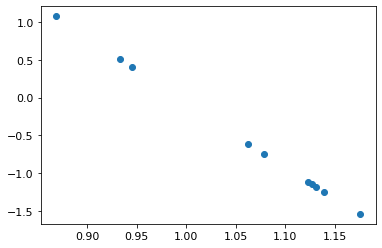

In [31]:
from scipy.spatial.distance import euclidean as Distance_scipy
dists = [Distance_scipy(*pos) for pos in test_pos]
sps = test_sps[:,0,0]
plt.plot(dists, sps, "o")
m, b = np.polyfit(dists, sps, 1)
r2 = np.corrcoef(dists, sps)[0,1]
print("Least-squares regresion produces the line m dist+b with m = {:.5f} and b = {:.5f} which has r2 = {:.5f} ".format(m, b, r2))


Least-squares regresion produces the line m dist+b with m = 0.62426 and b = -0.13122 which has r2 = 0.90914 


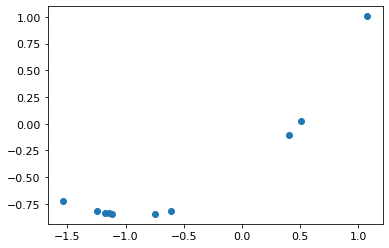

In [32]:
from scipy.spatial.distance import euclidean as Distance_scipy
sps = test_sps[:,0,0]
ens = test_ens
plt.plot(sps, ens, "o")
m, b = np.polyfit(sps, ens, 1)
r2 = np.corrcoef(sps, ens,)[0,1]
print("Least-squares regresion produces the line m dist+b with m = {:.5f} and b = {:.5f} which has r2 = {:.5f} ".format(m, b, r2))


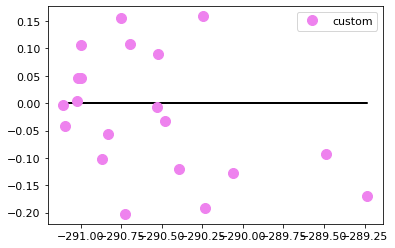

In [96]:
plot_custom = True; plot_nll = False
plt.plot(test_ens_rescaled, np.zeros(len(test_ens)), "-", c="k")
if plot_custom:
    plt.plot(test_ens_rescaled, predict_ens_custom_rescaled-test_ens_rescaled ,"o", label="custom", c="violet", ms=10)
if plot_nll:
    plt.plot(test_ens_rescaled, predict_ens_nll_rescaled-test_ens_rescaled ,"o", label="nll", c="lime", ms=5)
plt.legend()


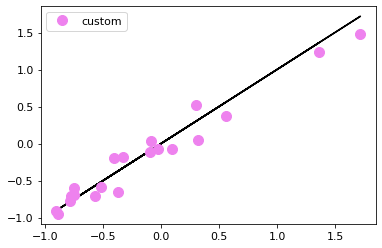

In [97]:
plot_custom = True; plot_nll = False
plt.plot(test_ens, test_ens, "-", c="k")
if plot_custom:
    plt.plot(test_ens, predict_ens_custom ,"o", label="custom", c="violet", ms=10)
if plot_nll:
    plt.plot(test_ens, predict_ens_nll ,"o", label="nll", c="lime", ms=5)
plt.legend()

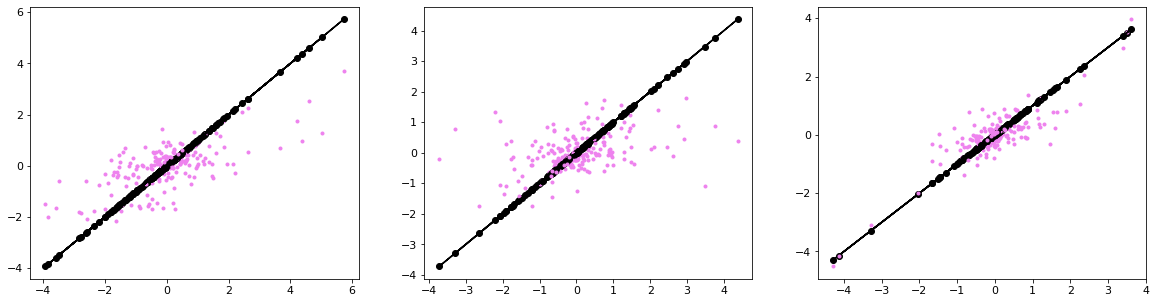

In [101]:

rescaled_test_frcs = test_frcs * ens_scaler.scale_
if plot_custom:
    rescaled_predict_frcs_custom =  predict_frcs_custom * ens_scaler.scale_
if plot_nll:
    rescaled_predict_frcs_nll = predict_frcs_nll * ens_scaler.scale_



fig, axs = plt.subplots(ncols=3, figsize=(20,5))
components = ["x", "y", "z"]

counts = [0,0,0]

for i in range(3):
    for j in range(rescaled_test_frcs.shape[1]):
        axs[i].plot(rescaled_test_frcs[:,j,i], rescaled_test_frcs[:,j,i], "o-", c="k")
        if plot_custom:
            axs[i].plot(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_custom[:,j,i], "o", label="custom", c="violet", ms=3)
            counts[i] +=1
#             try:
#                 print(i,j)
#                 m, b = np.polyfit(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_custom[:,j,i], 1)
#                 r2 = np.corrcoef(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_custom[:,j,i])[0,1]
#                 print("Least-squares regresion for F{}({}) produces the line line m {}+b with m = {:.5f} and b = {:.5f} which has r2 = {:.5f} ".format(components[i],components[i],components[i],m,b, r2))
#             except:
#                 pass        
        if plot_nll:
            axs[i].plot(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_nll[:,j,i], "o", label="nll", c="lime", ms=5)
    #axs[i].legend()

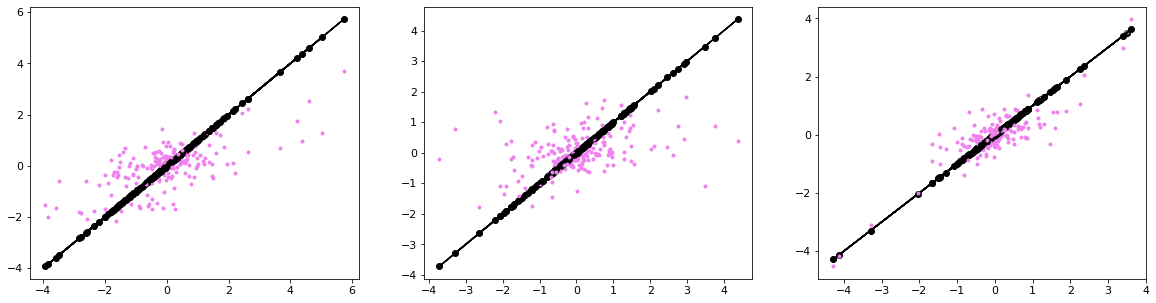

In [103]:

rescaled_test_frcs = test_frcs * ens_scaler.scale_
if plot_custom:
    rescaled_predict_frcs_custom =  predict_frcs_custom * ens_scaler.scale_
if plot_nll:
    rescaled_predict_frcs_nll = predict_frcs_nll * ens_scaler.scale_



fig, axs = plt.subplots(ncols=3, figsize=(20,5))
components = ["x", "y", "z"]

counts = [0,0,0]

for i in range(3):
    for j in range(rescaled_test_frcs.shape[1]):
        axs[i].plot(rescaled_test_frcs[:,j,i], rescaled_test_frcs[:,j,i], "o-", c="k")
        if plot_custom:
            axs[i].plot(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_custom[:,j,i], "o", label="custom", c="violet", ms=3)
            counts[i] +=1
#             try:
#                 print(i,j)
#                 m, b = np.polyfit(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_custom[:,j,i], 1)
#                 r2 = np.corrcoef(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_custom[:,j,i])[0,1]
#                 print("Least-squares regresion for F{}({}) produces the line line m {}+b with m = {:.5f} and b = {:.5f} which has r2 = {:.5f} ".format(components[i],components[i],components[i],m,b, r2))
#             except:
#                 pass        
        if plot_nll:
            axs[i].plot(rescaled_test_frcs[:,j,i], rescaled_predict_frcs_nll[:,j,i], "o", label="nll", c="lime", ms=5)
    #axs[i].legend()

---

Now with polynomial kernel

In [78]:
# This is my attempt at learning forces 
# Doesn't use LearnEnergyFromSoap because force learning is not yet implemented there (as of July 13th)

split_seed = 1
valid_split_seed = 1
training_frac = 0.9
valid_fract = 0.9

split_data = train_test_split(SoapList, SoapDerivativeList, EnergyList, ForceList, PosList, range(len(SoapList)), 
                              random_state=split_seed, test_size=(1-training_frac))
train_sps, test_sps, train_d_sps, test_d_sps, train_ens, test_ens, train_frcs, test_frcs, train_pos, test_pos, train_indices, test_indices = split_data

# scaling
# Standardize input for improved learning. Fit is done only on training data, scaling is applied to 
# both descriptors and their derivatives on training and test sets.
# # pass with_mean=False to avoid breaking sparsity structure of data
# soap_scaler = StandardScaler().fit(train_sps.reshape(-1,train_sps.shape[-1]))
# train_sps, test_sps = soap_scaler.transform(train_sps), soap_scaler.transform(test_sps)
# train_d_sps = train_d_sps / soap_scaler.scale_[None, None, None, :]
# test_d_sps = test_d_sps / soap_scaler.scale_[None, None, None, :]

# # Should I also rescale energies and/or forces?
# # For now I will
# ens_scaler = StandardScaler().fit(train_ens)
# train_ens, test_ens = ens_scaler.transform(train_ens), ens_scaler.transform(test_ens)
# train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
# test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

ens_scaler = StandardScaler().fit(train_ens[:,None])
train_ens, test_ens = ens_scaler.transform(train_ens[:,None])[:,0], ens_scaler.transform(test_ens[:,None])[:,0]
train_frcs = train_frcs / ens_scaler.scale_#[None, :, None]
test_frcs = test_frcs / ens_scaler.scale_#[None, :, None]

# # Should the variance be calculated before the rescaling?
ens_var = train_ens.var(); frcs_var = train_frcs.var()

#observation_index_points= tf.constant(np.array(train_pos), dtype=np.float64)
observation_index_points= tf.constant(train_sps, dtype=np.float64)
ens_observations = tf.constant(train_ens, dtype=np.float64)
frcs_observations = tf.constant(train_frcs, dtype=np.float64)
#index_points = tf.constant(np.array(test_pos), dtype=np.float64)
index_points = tf.constant(test_sps, dtype=np.float64)
#
shuffle_seed = 1
batch_size = 3
batch_size_custom_mse_max = 100
learn_rate = 0.05
n_epochs = 21; n_epochs_nll = n_epochs; n_epochs_custom = n_epochs
iterations_per_epoch = int(len(train_ens)/batch_size)
#


# initialize kernels and model hyperparameters
# ----------------------------------------------------------------------------------------
noise_init = 1e2; bias_var_init = 1e-10; slope_var_init=1e2
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
# nll (old approach)
exp_nll = tf.constant(2.0, dtype=np.float64)
bias_variance_nll = tfp.util.TransformedVariable(initial_value=bias_var_init, bijector=constrain_positive, dtype=np.float64, name="bias_var_nll")
slope_variance_nll = tfp.util.TransformedVariable(initial_value=slope_var_init, bijector=constrain_positive, dtype=np.float64, name="slope_var_nll")
obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
p_kernel_nll = tfk.Polynomial(exponent=exp_nll, slope_variance=slope_variance_nll, bias_variance=bias_variance_nll, name="p_kernel_nll", feature_ndims=1)#SoapList.shape[1])
trainable_variables_nll = [var.variables[0] for var in [ obs_noise_nll, bias_variance_nll, slope_variance_nll]]
# mostly mse, my custom approach
# allows for forces to be considered during training
obs_noise_custom = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_custom")
exp_custom = tf.constant(2.0, dtype=np.float64)
p_kernel_custom = tfk.Polynomial(exponent=exp_custom, name="p_kernel_custom", feature_ndims=1)#SoapList.shape[1])
trainable_variables_custom = [var.variables[0] for var in [obs_noise_custom]]
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# old/nll approach
# ----------------------------------------------------------------------------------------
#@tf.function(autograph=False, experimental_compile=False)
def loss_nll(index_points, observations):
    gp = tfd.GaussianProcess(kernel=p_kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)
    #print("index_points.shape = ", index_points.shape)
    #print("observations.shape = ", observations.shape)
    return -gp.log_prob(observations)

# Define mini-batch data iterator
batches_nll = (
    tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations))
    .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
    .repeat(count=None)
    .batch(batch_size)
)
#

optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate)

for j in range(n_epochs):
    loss_nll_j = 0
    for i, (index_points_i, ens_observations_i) in enumerate(islice(batches_nll, iterations_per_epoch)):
        with tf.GradientTape() as tape:
            loss_nll_i = loss_nll(index_points_i, ens_observations_i)
            loss_nll_i = tf.constant(loss_nll_i, dtype=np.float64)
            loss_nll_j += loss_nll_i
        grads = tape.gradient(loss_nll_i, trainable_variables_nll)
        optimizer.apply_gradients(zip(grads, trainable_variables_nll))
    if not j % 10:
        print("Old learning, epoch {} loss: {:10.0f}".format(j, loss_nll_j))
        print(bias_variance_nll)
        print(slope_variance_nll)

with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
    tape_d_ens.watch(index_points)    
    gprm_nll = tfd.GaussianProcessRegressionModel(
        kernel=kernel_nll,
        index_points=index_points,
        observation_index_points=observation_index_points,
        observations=ens_observations,
        observation_noise_variance=obs_noise_nll)
    print(index_points.shape)
    print(observation_index_points.shape)
    print(ens_observations.shape)
    predict_ens_nll = gprm_nll.mean()

predict_d_ens_nll = tape_d_ens.gradient(predict_ens_nll, index_points)
#print(predict_d_ens_nll[:1])
#predict_d_ens_nll = predict_d_ens_nll[:,0,:]
#print(predict_d_ens_nll[:1])

print("predict_d_ens_nll.shape =", predict_d_ens_nll.shape)
print("test_d_sps.shape = ", test_d_sps.shape )
print("\ntest_d_sps[0][:,:,0] = \n", test_d_sps[0][:,:,0])
print("\npredict_d_ens_nll[0] = \n", predict_d_ens_nll[0])
predict_frcs_nll = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_nll)#[:,1] # only get force of one atom while we are doing global soap
print("\npredict_frcs_nll[0][:,0] = \n", predict_frcs_nll[0][:,0])

# predict_d_ens_nll.shape = (75, 2, 18)
# test_d_sps.shape =  (75, 2, 2, 3, 18)
#     print("test_d_sps", test_d_sps)
#     print("predict_d_ens_nll", predict_d_ens_nll)
#     print("predict_frcs_nll", -1*np.einsum('ijkl,il->ijk', test_d_sps, predict_d_ens_nll))
# ----------------------------------------------------------------------------------------


# ----------------------------------------------------------------------------------------
# custom/mostly mse approach
# ----------------------------------------------------------------------------------------
if False:
    @tf.function(autograph=False, experimental_compile=False)
    def loss_custom_nll(index_points, observations):
        gp = tfd.GaussianProcess(kernel=kernel_custom, index_points=index_points, observation_noise_variance=obs_noise_custom)
        return -gp.log_prob(observations)

    @tf.function(autograph=False, experimental_compile=False)
    def mse(y_predict, y_true):
        return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

    #@tf.function(autograph=False, experimental_compile=False)
    def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
        mse1 = mse(y1_predict, y1_true)
#         print("mse1 = ", mse1)
        mse2 = mse(y2_predict, y2_true)
#         print("mse2 = ", mse2)
        return mse1 * weight1 + mse2 * weight2

    # batch it
    batches_custom = (
        tf.data.Dataset.from_tensor_slices((observation_index_points, ens_observations, frcs_observations))
        .shuffle(buffer_size=len(observation_index_points), seed=shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )

    optimizer_custom = tf.keras.optimizers.Adam(learning_rate=learn_rate)

    # First run through the data a few times, minimizing nll because this is more robust to bad hyperparameter initialization
    n_epochs_custom_nll = 3
    for j in range(n_epochs_custom_nll):
        for i, (index_points_i, ens_observations_i, ignore_forces_here) in enumerate(islice(batches_custom, iterations_per_epoch)):
                with tf.GradientTape() as tape:
                    loss_custom_i = loss_custom_nll(index_points_i, ens_observations_i)
                    loss_custom_i = tf.constant(loss_custom_i, dtype=np.float64)
                grads = tape.gradient(loss_custom_i, trainable_variables_custom)
                optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))

    for j in range(n_epochs_custom):
        if not j % 10:
            print("Custom learning, epoch {}".format(j+1))

        split_data_j = train_test_split(train_sps, train_ens, train_d_sps, train_frcs, random_state =valid_split_seed+j, test_size=(1-valid_fract))
        train_sps_j, valid_sps_j, train_ens_j, valid_ens_j, train_d_sps_j, valid_d_sps_j, train_frcs_j, valid_frcs_j = split_data_j
        observation_index_points_j = tf.constant(train_sps_j, dtype=np.float64)
        ens_observations_j = tf.constant(train_ens_j, dtype=np.float64)
        d_sps_observations_j = tf.constant(train_d_sps_j, dtype=np.float64)
        frcs_observations_j = tf.constant(train_frcs_j, dtype=np.float64)
        heldout_index_points_j = tf.constant(valid_sps_j, dtype=np.float64)
        heldout_ens_observations_j = tf.constant(valid_ens_j, dtype=np.float64)
        heldout_d_sps_observations_j = tf.constant(valid_d_sps_j, dtype=np.float64)
        heldout_frcs_observations_j = tf.constant(valid_frcs_j, dtype=np.float64)

        if len(train_sps_j) < batch_size_custom_mse_max:
            iterations_per_epoch_custom = 1
            batch_size_custom = len(train_sps_j)
        else:
            iterations_per_epoch_custom = int(np.ceil(len(train_sps_j)/batch_size_custom_mse_max))
            batch_size_custom = int(np.ceil(len(train_sps_j)/iterations_per_epoch_custom))

        batches_custom_j = (
            tf.data.Dataset.from_tensor_slices((observation_index_points_j, ens_observations_j, d_sps_observations_j, frcs_observations_j)) # frcs_observations_j_i might be extraneous
            .shuffle(buffer_size=len(observation_index_points_j), seed=shuffle_seed) # Should I modify this to be seed = shuffle_seed + j or does it not matter?
            .repeat(count=None)
            .batch(batch_size_custom)
        )
        for i, (index_points_j_i, ens_observations_j_i, d_sps_observations_j_i, frcs_observations_j_i) \
                in enumerate(islice(batches_custom_j, iterations_per_epoch_custom)):
            with tf.GradientTape() as tape:
                with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
                    tape_d_ens.watch(heldout_index_points_j)    
                    gprm_custom_j_i = tfd.GaussianProcessRegressionModel(
                        kernel = kernel_custom,
                        index_points = heldout_index_points_j,
                        observation_index_points = index_points_j_i,
                        observations = ens_observations_j_i,
                        observation_noise_variance = obs_noise_custom)
                    predict_ens_j_i = gprm_custom_j_i.sample()
                predict_d_ens_j_i = tape_d_ens.gradient(predict_ens_j_i, heldout_index_points_j)
                #predict_frcs_j_i = -predict_d_ens_j_i
                predict_frcs_j_i = -1*np.einsum('imjkl,il->ijk', heldout_d_sps_observations_j, predict_d_ens_j_i)#[:,1] # only get force of one atom while we are doing global soap
                error_custom_j_i = mse_2factor(predict_ens_j_i, heldout_ens_observations_j, 1/ens_var,
                                               predict_frcs_j_i, heldout_frcs_observations_j, 1/frcs_var)
#                 print("predict_ens_j_i = ", predict_ens_j_i)
#                 print("heldout_ens_observations_j = ", heldout_ens_observations_j)
#                 print("1/ens_var = ", 1/ens_var)
#                 print("predict_frcs_j_i = ", predict_frcs_j_i)
#                 print("heldout_frcs_observations_j = ", heldout_frcs_observations_j)
#                 print("1/frcs_var = ",1/frcs_var)
#                 print("error value is ", error_custom_j_i)

            grads = tape.gradient(error_custom_j_i, trainable_variables_custom)
            optimizer_custom.apply_gradients(zip(grads, trainable_variables_custom))


    with tf.GradientTape(watch_accessed_variables=False) as tape_d_ens:
        tape_d_ens.watch(index_points)    

        gprm_custom = tfd.GaussianProcessRegressionModel(
            kernel=kernel_custom,
            index_points=index_points,
            observation_index_points=observation_index_points,
            observations=ens_observations,
            observation_noise_variance=obs_noise_custom)

        predict_ens_custom = gprm_custom.mean()

    predict_d_ens_custom = tape_d_ens.gradient(predict_ens_custom, index_points)
    #predict_frcs_custom = -predict_d_ens_custom.numpy()
    predict_frcs_custom = -1*np.einsum('imjkl,il->ijk', test_d_sps, predict_d_ens_custom)#[:,1] # only get force of one atom while we are doing global soap
# -------------------------------------------------------------------



Old learning, epoch 0 loss:       1036
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=9.999999999999996e-11>
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=5.264346569566937>
Old learning, epoch 10 loss:        257
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=9.999999999994347e-11>
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=0.0003167384302860716>
Old learning, epoch 20 loss:        256
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=9.999999999992962e-11>
<TransformedVariable: dtype=float64, shape=[], fn="chain_of_shift_of_exp", numpy=0.00027292594941086983>
(20, 2)
(180, 2)
(180,)
predict_d_ens_nll.shape = (20, 2)
test_d_sps.shape =  (20, 112, 112, 3, 2)

test_d_sps[0][:,:,0] = 
 [[[ 0.0000000e+00  1.8211912e-01]
  [-1.1813260e+01 -2.8771907e-01]
  [-1.8961560e+00 -1.3441440e-01]
  ...
  [-1.6820769e-01 -7.498376

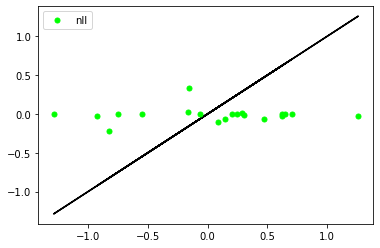

In [80]:
plot_custom = False; plot_nll = True
plt.plot(test_ens, test_ens, "-", c="k")
if plot_custom:
    plt.plot(test_ens, predict_ens_custom,"o", label="custom", c="violet", ms=10)
if plot_nll:
    plt.plot(test_ens, predict_ens_nll,"o", label="nll", c="lime", ms=5)
plt.legend()

In [57]:
noise_init = 1e-5; amp_init = 1; len_init = 3
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())
# nll (old approach)
obs_noise_nll = tfp.util.TransformedVariable(initial_value=noise_init, bijector=constrain_positive, dtype=np.float64, name="noise_nll")
amplitude_nll = tfp.util.TransformedVariable(initial_value=amp_init, bijector=constrain_positive, dtype=np.float64, name="amplitude_nll")
len_scale_nll = tfp.util.TransformedVariable(initial_value=len_init, bijector=constrain_positive, dtype=np.float64, name="len_scale_nll")
kernel_nll = tfk.ExponentiatedQuadratic(amplitude=amplitude_nll, length_scale=len_scale_nll, name="kernel_nll", feature_ndims=2)

In [58]:
def loss_nll(index_points, observations):

    gp = tfd.GaussianProcess(kernel=kernel_nll, index_points=index_points, observation_noise_variance=obs_noise_nll)
    print("index_points.shape = ", index_points.shape)
    print("observations.shape = ", observations.shape)
    return -gp.log_prob(observations)

def gprm(obs_index_points, observations, index_points):
    print("batch_shape = ", kernel_nll.batch_shape)
    print("feature dimensions = ", kernel_nll.feature_ndims)
    print("obs_index_points.shape = ", obs_index_points.shape)    
    print("observations.shape = ", observations.shape)
    print("index_points.shape = ", index_points.shape)
    gprm_nll = tfd.GaussianProcessRegressionModel(
        kernel=kernel_nll,
        index_points=index_points,
        observation_index_points=obs_index_points,
        observations=observations,
        observation_noise_variance=obs_noise_nll)
    return gprm_nll.mean()

test_xs = tf.constant(rand.random(( 5,  2, 18)), dtype=np.float64)
xs = tf.constant(rand.random((3, 2, 18)), dtype=np.float64)
ys = rand.random(3)
#ys[0] = [300 for y in ys[0]]
ys = tf.constant(ys, dtype=np.float64)
PrintNoScientificNotation("predicitons = ", gprm(xs, ys,test_xs))
# This is not what we want
# The first (batch) dimension is only used to predict corresponding outputs

batch_shape =  ()
feature dimensions =  2
obs_index_points.shape =  (3, 2, 18)
observations.shape =  (3,)
index_points.shape =  (5, 2, 18)
predicitons =  tf.Tensor([0.38338199 0.58308328 0.43920567 0.54515858 0.59879727], shape=(5,), dtype=float64)


# Save as script 

The following cell will save this notebook as a python script

In [1]:
!jupyter nbconvert --to script miniGAP.ipynb --output latest_miniGAP

[NbConvertApp] Converting notebook miniGAP.ipynb to script
[NbConvertApp] Writing 69372 bytes to latest_miniGAP.py
